In [4]:
import dask.dataframe as dd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
import re
import pandas as pd
from scipy.spatial.distance import cosine
import requests
import ast  
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

from dask.diagnostics import ProgressBar

In [9]:
# General function to process text
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text):  
        return ""
    text = text.lower()  
    text = re.sub(r'\W', ' ', text)  
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words and word.isalpha() and len(word) > 3]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/clementine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load NYT dataset

In [2]:
ddf = dd.read_parquet('nyt_data.parquet')

In [67]:
# Select a time period and compute
with ProgressBar():
    filtered_ddf = ddf[(ddf['year'] >= 1950) & (ddf['year'] <= 2000)].compute()

filtered_ddf = dd.from_pandas(filtered_ddf, npartitions=100)

# Select only a tiny fraction
filtered_ddf = filtered_ddf.sample(frac=0.01, random_state=42).reset_index(drop=True)


[########################################] | 100% Completed | 95.91 s


In [68]:
# Create a combined text field for further analysis
filtered_ddf['combined_text'] = filtered_ddf['title'] + filtered_ddf['excerpt']
filtered_ddf['processed_text'] = filtered_ddf['combined_text'].apply(preprocess_text, meta=('processed_text', 'str'))

## Load Movie Dataset

In [35]:
file_path = "plot_summaries.txt"

ids_test = []
movies_dict = {}

# Open and read the file
with open(file_path, 'r', encoding='utf-8') as file:
    
    # Read each line
    for line in file:
        line = line.strip()
        if '\t' in line:
            movie_id, description = line.split('\t', 1)
            
            # Store each movie as a dictionary entry
            movies_dict[int(movie_id)] = description

In [36]:

col_names = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date','Movie box office revenue', 'Movie runtime', 'Movie languages','Movie countries', 'Movie genres']
df_movies = pd.read_csv('movie.metadata.tsv', sep='\t', header=None, names=col_names)

In [37]:
# Reformate dates
df_movies['Movie release date'] = pd.to_datetime(df_movies['Movie release date'], errors='coerce', format='%Y-%m-%d')

df_movies['Movie release date'] = df_movies['Movie release date'].fillna(
    pd.to_datetime(df_movies['Movie release date'].astype(str) + '-01-01', errors='coerce')
)

df_movies['Release Year'] = df_movies['Movie release date'].dt.year

/var/folders/yv/ssvypmfx4nx84w2sfd3q2mnc0000gn/T/ipykernel_42558/3964647369.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df_movies['Movie release date'].astype(str) + '-01-01', errors='coerce')
/var/folders/yv/ssvypmfx4nx84w2sfd3q2mnc0000gn/T/ipykernel_42558/3964647369.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_movies['Movie release date'] = df_movies['Movie release date'].fillna(


In [38]:
df_movies

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Release Year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0
2,28463795,/m/0crgdbh,Brun bitter,NaT,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN
3,9363483,/m/0285_cd,White Of The Eye,NaT,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",NaN
4,261236,/m/01mrr1,A Woman in Flames,NaT,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",NaN
...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011.0
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011.0
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972.0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992.0


In [39]:
# Select period of time
start_date = 1950
end_date = 2000

df_movies = df_movies[(df_movies['Release Year'] >= start_date) & (df_movies['Release Year'] < end_date)]


In [40]:
# Create lists
ids = df_movies["Wikipedia movie ID"].to_list()
movies_dict = {k: movies_dict[k] for k in movies_dict if k in ids}
movie_descriptions = list(movies_dict.values())
movie_ids = list(movies_dict.keys())

## Launch Model for movies

In [13]:
# Load the model
model = SentenceTransformer("all-MiniLM-L6-v2")

In [14]:
# Encode the query
query_embedding = model.encode(["women's rights"])

In [42]:
movie_embeddings = model.encode(movie_descriptions, batch_size=64)

In [43]:
np.save('movie_embeddings5020.npy', movie_embeddings)

In [44]:
# Calculate similarity with the query
similarities = cosine_similarity(query_embedding, movie_embeddings).flatten()
ids = [movie_ids[i] for i, sim in enumerate(similarities) if sim > 0.2]

In [45]:
df_movies_new = df_movies[df_movies['Wikipedia movie ID'].isin(ids)]
df_movies_new

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Release Year
163,9169526,/m/027_08f,Las Boludas,1993-08-05,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/01z4y"": ""Comedy""}",1993.0
220,20119316,/m/04yfw36,Eoudong,1985-09-28,NaN,110.0,{},"{""/m/06qd3"": ""South Korea""}","{""/m/07s9rl0"": ""Drama""}",1985.0
228,30173306,/m/0g59khw,Ab Insaf Hoga,1995-01-06,NaN,125.0,"{""/m/03k50"": ""Hindi Language""}",{},"{""/m/07s9rl0"": ""Drama""}",1995.0
380,24291753,/m/07s4ql2,The Careless Years,1957-09-02,NaN,88.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...",1957.0
432,4473622,/m/0c4fjm,Images,1972-12-18,NaN,101.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/09blyk"": ""Psycholo...",1972.0
...,...,...,...,...,...,...,...,...,...,...
81118,18118679,/m/04y663q,Torch Song Trilogy,1988-12-14,4865997.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hn10"": ""L...",1988.0
81137,14359569,/m/03d1n6b,Sandakan No. 8,1974-11-02,NaN,121.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/07s9rl0""...",1974.0
81177,32813277,/m/0bbbl5q,The Ambassador's Daughter,1956-07-26,1500000.0,103.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1956.0
81475,32158759,/m/0gwz7sp,Velutha Kathreena,1968-11-29,NaN,NaN,{},{},"{""/m/07s9rl0"": ""Drama""}",1968.0


## Launch model

In [70]:
# Encode the text
with ProgressBar():
    news = filtered_ddf['processed_text'].compute().tolist()  # Utilisation de compute() pour Dask
news_embeddings = model.encode(news, batch_size=64)

[########################################] | 100% Completed | 9.97 ss


In [71]:
# Save the result
np.save('news_embeddings.npy', news_embeddings)

In [72]:
filtered_ddf_pandas = filtered_ddf.compute()

In [99]:
# Calculate similarity with the query
similarities = cosine_similarity(query_embedding, news_embeddings).flatten()
similar_entries_indices = np.where(similarities >= 0.3)[0]
filtered_similar_ddf = filtered_ddf_pandas.iloc[similar_entries_indices].reset_index(drop=True)

In [100]:
filtered_similar_ddf['combined_text'][2]

'Barnard Coll gets Mrs F C Overbury collection stressing works by women BARNARD RECEIVES FIRST EDITIONS GIFTCollection of Mrs. Overbury Stresses Contributions of American Women'

## Plot evolution

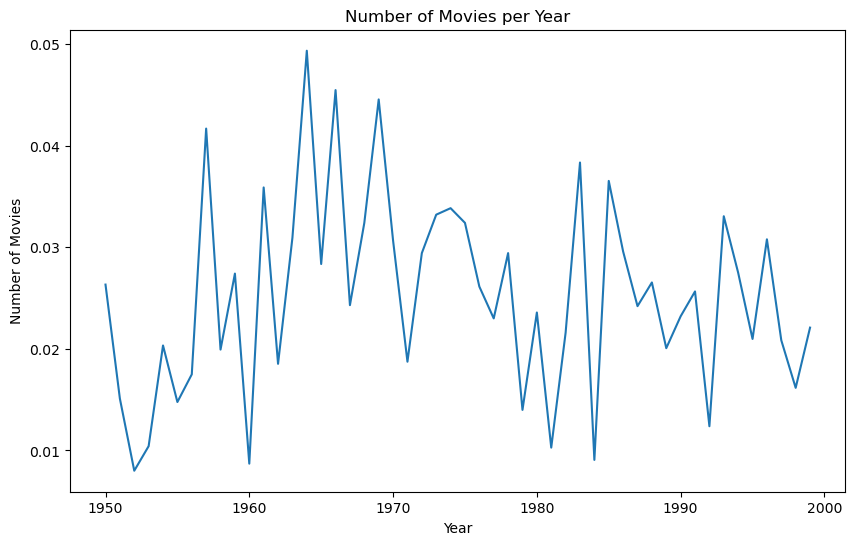

In [144]:

# Calculate the relative presence of the topic accross the years
count_per_year = df_movies_new.groupby('Release Year').size()
total_count_per_year = df_movies.groupby('Release Year').size()

relative_count_per_year = count_per_year / total_count_per_year

# Create the line plot
relative_count_per_year.plot(kind='line', figsize=(10, 6), title="Number of Movies per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")


plt.show()


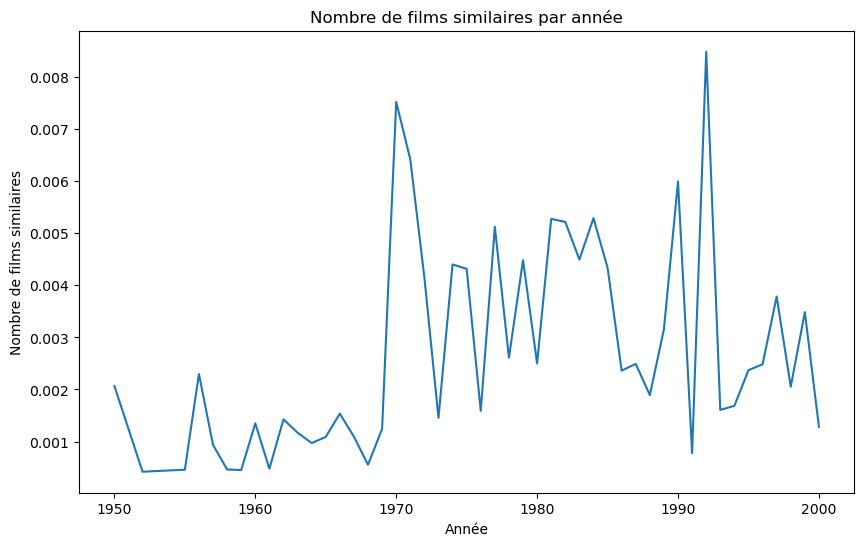

In [143]:

# Calculate the relative presence of the topic accross the years

count_per_year_similar = filtered_similar_ddf.groupby('year').size()

total_count_per_year_similar = filtered_ddf_pandas.groupby('year').size()

relative_count_per_year_similar = count_per_year_similar / total_count_per_year_similar

relative_count_per_year_similar = relative_count_per_year_similar.dropna()

# Line plot
relative_count_per_year_similar.plot(kind='line', figsize=(10, 6), title="Relative Number of news articles per Year")
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.show()



## TOPIC 2 

In [146]:
# Calculate similarity for the new topic
query_embedding_env = model.encode(["environmental issues"])

similarities_env = cosine_similarity(query_embedding_env, movie_embeddings).flatten()
ids_env = [movie_ids[i] for i, sim in enumerate(similarities_env) if sim > 0.2]

df_movies_new_env = df_movies[df_movies['Wikipedia movie ID'].isin(ids_env)]
df_movies_new_env

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Release Year
112,2154704,/m/06qv1c,Choke Canyon,1986-05-02,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0cq22f9"": ""Actio...",1986.0
560,2524925,/m/07kwyt,The Land Before Time III: The Time of the Grea...,1995-12-15,NaN,71.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03k9fj"": ""Adventure"", ""/m/0hj3myq"": ""Chil...",1995.0
2360,24954740,/m/09gq58_,The Terror Within II,1991-01-18,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""H...",1991.0
2555,27491558,/m/0b_zlz6,Country Town,1971-06-19,NaN,101.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0chghy"": ""Australia""}","{""/m/07s9rl0"": ""Drama""}",1971.0
2857,4180145,/m/0bnhc8,Alien Dead,1980-06-01,NaN,90.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0jb4p32"": ""Zombie Film"", ""/m/06n90"": ""Sci...",1980.0
...,...,...,...,...,...,...,...,...,...,...
73538,22558992,/m/05zv2kk,"Christmas Miracle in Caufield, U.S.A.",1977-12-26,NaN,97.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",1977.0
74206,7549834,/m/0kvb86,Honor Roll,1992-08-26,NaN,97.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/0hqxf"": ""Family Film"", ""/m/01z4y"": ""Comedy""}",1992.0
76584,25771135,/m/09v9mn7,The Chain Reaction,1980-09-25,NaN,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0chghy"": ""Australia""}","{""/m/01jfsb"": ""Thriller"", ""/m/02kdv5l"": ""Action""}",1980.0
77530,4221457,/m/0bqrg5,The Ice Pirates,1984-03-16,14255801.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0gf28"": ""Parody"", ""/m/06n90"": ""Science Fi...",1984.0


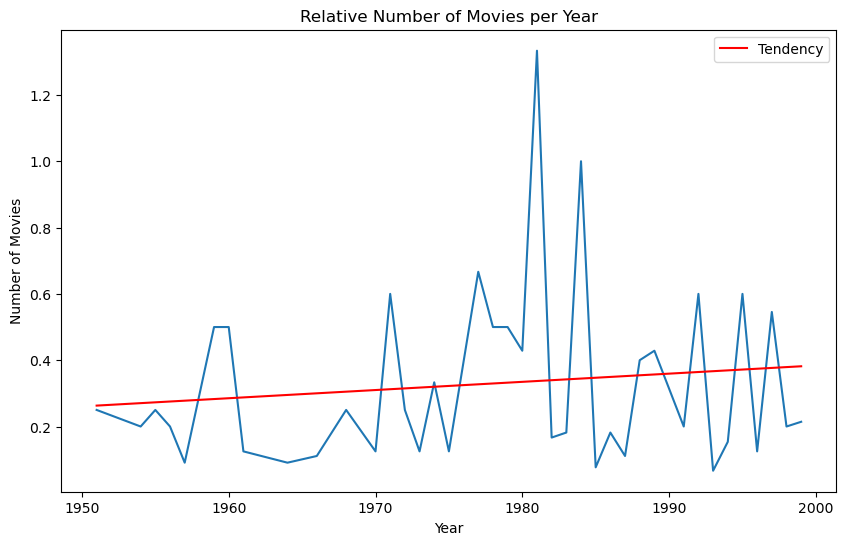

In [154]:
# Calculate the relative presence of the topic accross the years
count_per_year = df_movies_new_env.groupby('Release Year').size()

total_count_per_year = df_movies_new.groupby('Release Year').size()

relative_count_per_year = count_per_year / total_count_per_year

relative_count_per_year = relative_count_per_year.dropna()

# Create the line plot
relative_count_per_year.plot(kind='line', figsize=(10, 6), title="Relative Number of Movies per Year")
plt.xlabel("Year")
plt.ylabel("Number of Movies")

# Generate a linear regression line to the data
x = relative_count_per_year.index.astype(int)  # Ensure 'Year' is in integer format
y = relative_count_per_year.values
slope, intercept = np.polyfit(x, y, 1)  # 1 indicates a linear fit (degree 1 polynomial)

regression_line = slope * x + intercept

plt.plot(x, regression_line, color='red', label='Tendency')
plt.legend()

plt.show()

In [148]:
# Calculate similarity with new query
similarities_env_news = cosine_similarity(query_embedding_env, news_embeddings).flatten()
similar_entries_indices_env_news = np.where(similarities_env_news >= 0.4)[0]
filtered_similar_ddf_env_news = filtered_ddf_pandas.iloc[similar_entries_indices_env_news].reset_index(drop=True)

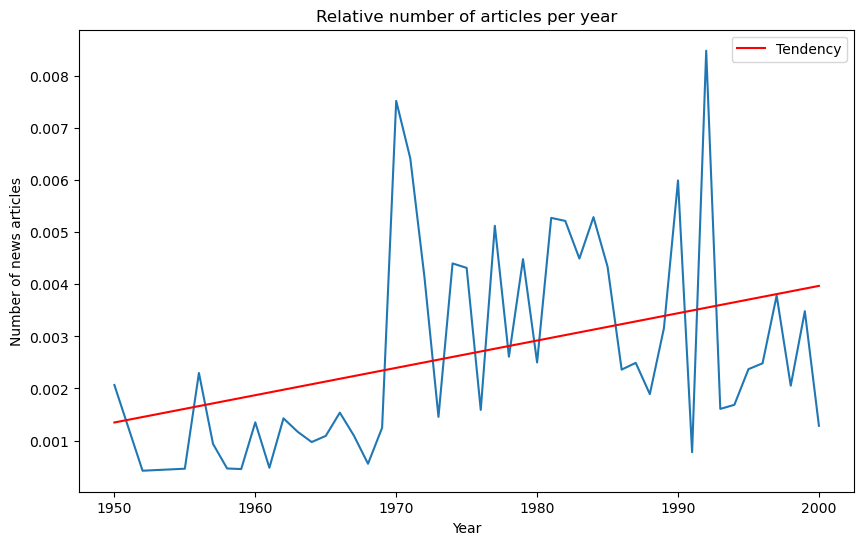

In [153]:
# Calculate the relative presence of the topic accross the years
count_per_year_similar = filtered_similar_ddf_env_news.groupby('year').size()

relative_count_per_year_similar = count_per_year_similar / total_count_per_year_similar

relative_count_per_year_similar = relative_count_per_year_similar.dropna()

# Créer un line plot
relative_count_per_year_similar.plot(kind='line', figsize=(10, 6), title="Relative number of articles per year")
plt.xlabel("Year")
plt.ylabel("Number of news articles")

# Generate a linear regression line to the data
x = relative_count_per_year_similar.index.astype(int)  
y = relative_count_per_year_similar.values
slope, intercept = np.polyfit(x, y, 1) 

regression_line = slope * x + intercept

plt.plot(x, regression_line, color='red', label='Tendency')
plt.legend()

plt.show()
plt.show()